In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D, Dropout ,BatchNormalization
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

2025-08-06 14:02:25.572365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754488945.935479      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754488946.038676      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'

In [4]:
filepaths = []
labels = []

folds = os.listdir(data)

for fold in folds:
    files = os.path.join(data , fold)
    filelist = os.listdir(files)
    for fpath in filelist:
        fillpath = os.path.join(files , fpath)

        filepaths.append(fillpath)
        labels.append(fold)

df = pd.DataFrame({'filepaths':filepaths , 'Labels':labels})

In [5]:
df

,filepaths,Labels
0,/kaggle/input/brain-mri-images-for-brain-tumor...,no
1,/kaggle/input/brain-mri-images-for-brain-tumor...,no
2,/kaggle/input/brain-mri-images-for-brain-tumor...,no
3,/kaggle/input/brain-mri-images-for-brain-tumor...,no
4,/kaggle/input/brain-mri-images-for-brain-tumor...,no
...,...,...
250,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
251,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
252,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
253,/kaggle/input/brain-mri-images-for-brain-tumor...,brain_tumor_dataset


In [6]:
strat = df['Labels']

train, test = train_test_split(df , test_size = 0.2 , shuffle = True , random_state = 42 , stratify= strat)

In [7]:
img_size = 224
batch_size = 32
channels = 3

In [8]:
data_gen = ImageDataGenerator(rescale=1./255,)
                              

train_data = data_gen.flow_from_dataframe(train,
                                          x_col = 'filepaths',
                                          y_col = 'Labels',
                                          target_size = (img_size , img_size),
                                          batch_size=batch_size,
                                          class_mode = 'categorical',
                                          color_mode = 'rgb',
                                          shuffle = True)

test_data = data_gen.flow_from_dataframe(test,
                                         x_col = 'filepaths',
                                         y_col = 'Labels',
                                         target_size = (img_size , img_size),
                                         batch_size=batch_size,
                                         class_mode = 'categorical',
                                         color_mode = 'rgb',
                                         shuffle = False
                                         )

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


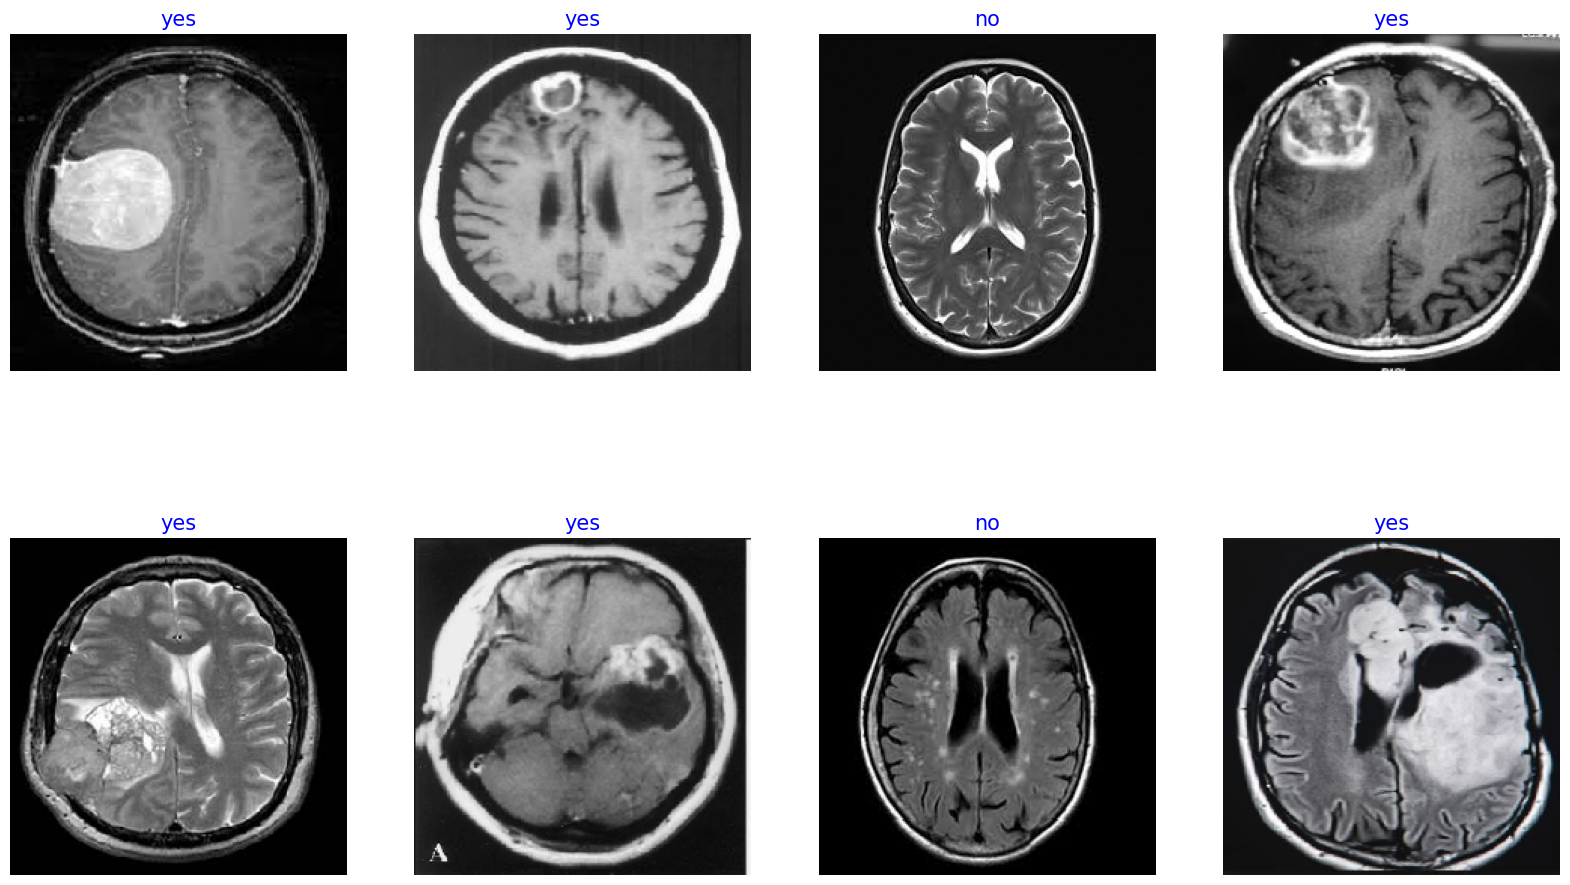

In [9]:
classes = train_data.class_indices      
classes = list(classes.keys())

images , labels = next(train_data)
plt.figure(figsize = (20,12))

for i in range(8):
    plt.subplot(2 , 4 , i+1)
    image = images[i]
    plt.imshow(image)

    label = np.argmax(labels[i])
    class_name = classes[label]
    plt.title(class_name, color= 'blue', fontsize= 15)
    plt.axis('off')
plt.show()
    

In [10]:
base_model = tf.keras.applications.ResNet50V2(input_shape = (img_size , img_size , channels) , include_top = False , weights = 'imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalMaxPool2D()(x)
x = Dense(256 , activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(64 , activation = 'relu')(x)
predictions = Dense(2 , activation = 'softmax')(x)

model_ResNet50V2 = Model(inputs = base_model.input , outputs = predictions)

I0000 00:00:1754489029.243929      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754489029.244703      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)

model_ResNet50V2.compile(optimizer = optimizer , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5, restore_best_weights=True , monitor='val_loss')

epochs = 20

history = model_ResNet50V2.fit(train_data,
                        epochs = epochs,
                        batch_size = batch_size,
                        validation_data = test_data,
                        callbacks = [earlystop])

Epoch 1/20


I0000 00:00:1754489050.322808     104 service.cc:148] XLA service 0x78da80011e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754489050.324532     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754489050.324558     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754489051.726400     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5078 - loss: 3.3924 

I0000 00:00:1754489058.892941     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5414 - loss: 2.7391 - val_accuracy: 0.6471 - val_loss: 1.7967
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6719 - loss: 1.4657 - val_accuracy: 0.8431 - val_loss: 0.3250
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.7265 - loss: 0.9344 - val_accuracy: 0.8431 - val_loss: 0.3628
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.7628 - loss: 0.6882 - val_accuracy: 0.7843 - val_loss: 0.5654
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8415 - loss: 0.4114 - val_accuracy: 0.9020 - val_loss: 0.3299
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.8448 - loss: 0.4282 - val_accuracy: 0.9216 - val_loss: 0.4044
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8716 - loss: 0.2331 - val_accuracy: 0.9020 - val_loss: 0.4664


In [13]:
loss , accuarcy = model_ResNet50V2.evaluate(test_data)
print(f'The Loss : {loss}')
print(f'The accuarcy : {accuarcy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8329 - loss: 0.3316 
The Loss : 0.3249957859516144
The accuarcy : 0.843137264251709


In [14]:
train_score = model_ResNet50V2.evaluate(train_data, verbose= 1)
test_score = model_ResNet50V2.evaluate(test_data, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.8338 - loss: 0.4161
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8329 - loss: 0.3316 
Train Loss:  0.43267661333084106
Train Accuracy:  0.8267326951026917
--------------------
Test Loss:  0.3249957859516144
Test Accuracy:  0.843137264251709


In [15]:
preds = model_ResNet50V2.predict(test_data)
y_pred = np.argmax(preds, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step


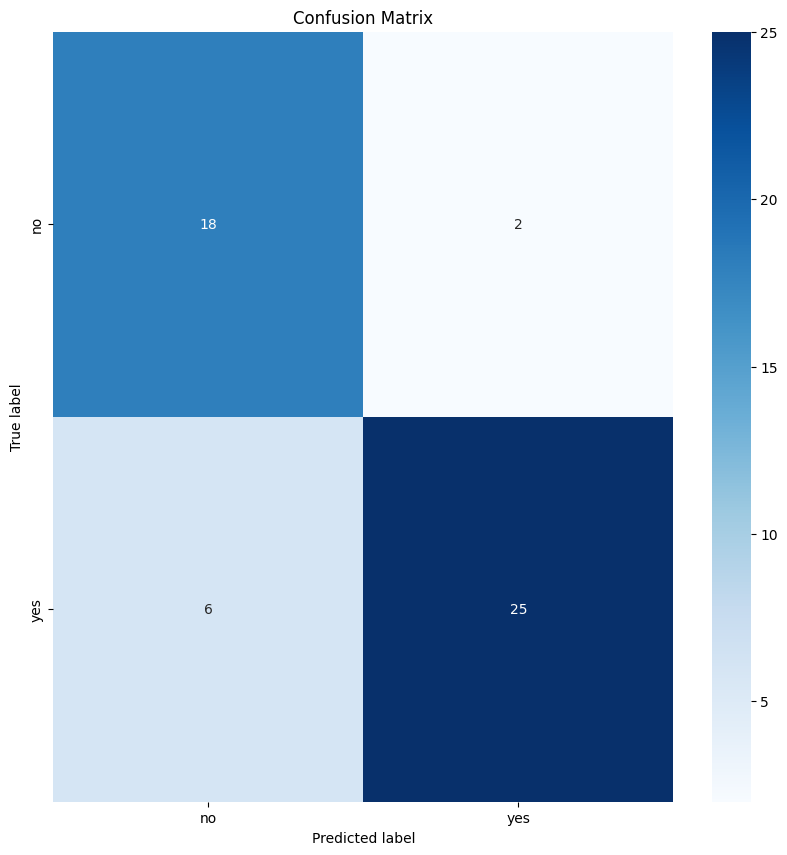

In [16]:
g_dict = test_data.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_data.classes, y_pred)

plt.figure(figsize= (10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
print(classification_report(test_data.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          no       0.75      0.90      0.82        20
         yes       0.93      0.81      0.86        31

    accuracy                           0.84        51
   macro avg       0.84      0.85      0.84        51
weighted avg       0.86      0.84      0.84        51



In [18]:
model_ResNet50V2.save('brain_tumor_classifier.keras')

In [19]:
from IPython.display import FileLink
FileLink('brain_tumor_classifier.keras')

/kaggle/working/brain_tumor_classifier.keras